In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

# Load the data
d = pd.read_csv('../Data/Howell1.csv', sep=';', header=0)
d = d[d.age >= 18]
d['weight_c'] = d.weight - d.weight.mean()

##### 4E1
Line 1 is the likelihood, the other lines are priors

##### 4E2
2 parameters

##### 4E3
see overthinking box in page 83

##### 4E4
Line 2

##### 4E1
There are 3 parameters



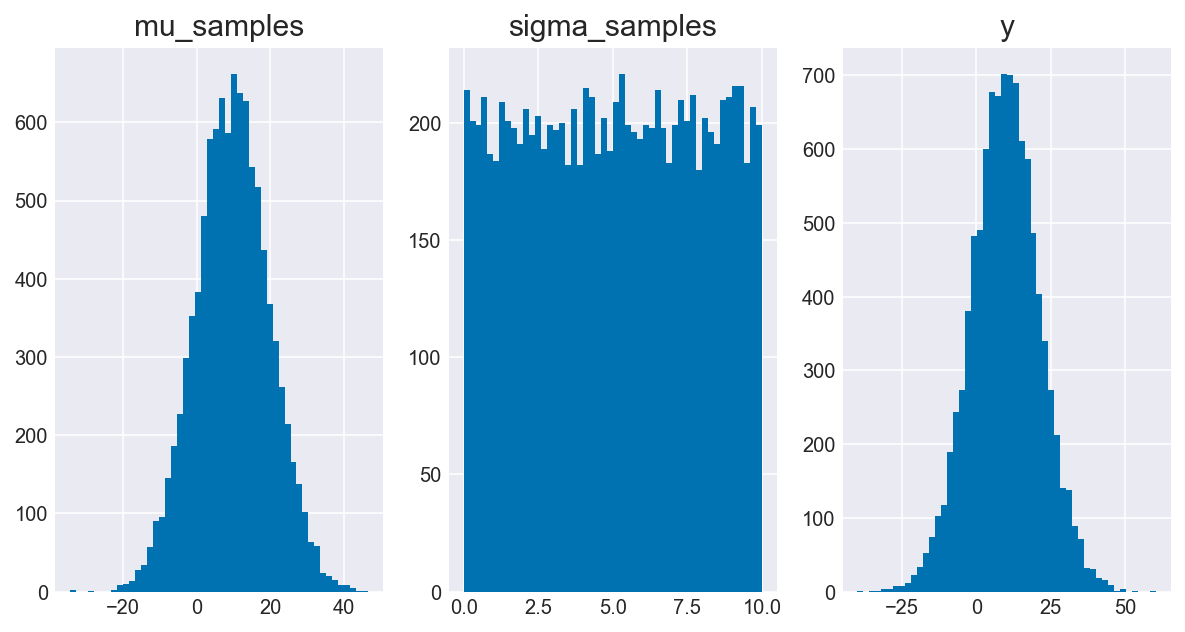

In [51]:
# 4M1
# Simulating priors
mu_samples = np.random.normal(10, 10, size=10000)
sigma_samples = np.random.uniform(0,10, size=10000)
y = np.random.normal(mu_samples, sigma_samples)

_, axes = plt.subplots(1,3, figsize=(10,5))
axes[0].hist(mu_samples, bins=50)
axes[1].hist(sigma_samples, bins=50)
axes[2].hist(y, bins=50)
axes[0].set_title('mu_samples', fontsize=15)
axes[1].set_title('sigma_samples', fontsize=15)
axes[2].set_title('y', fontsize=15);


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [y, sigma, mu]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:04<00:00, 998.12draws/s] 
There were 72 divergences after tuning. Increase `target_accept` or reparameterize.
There were 78 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


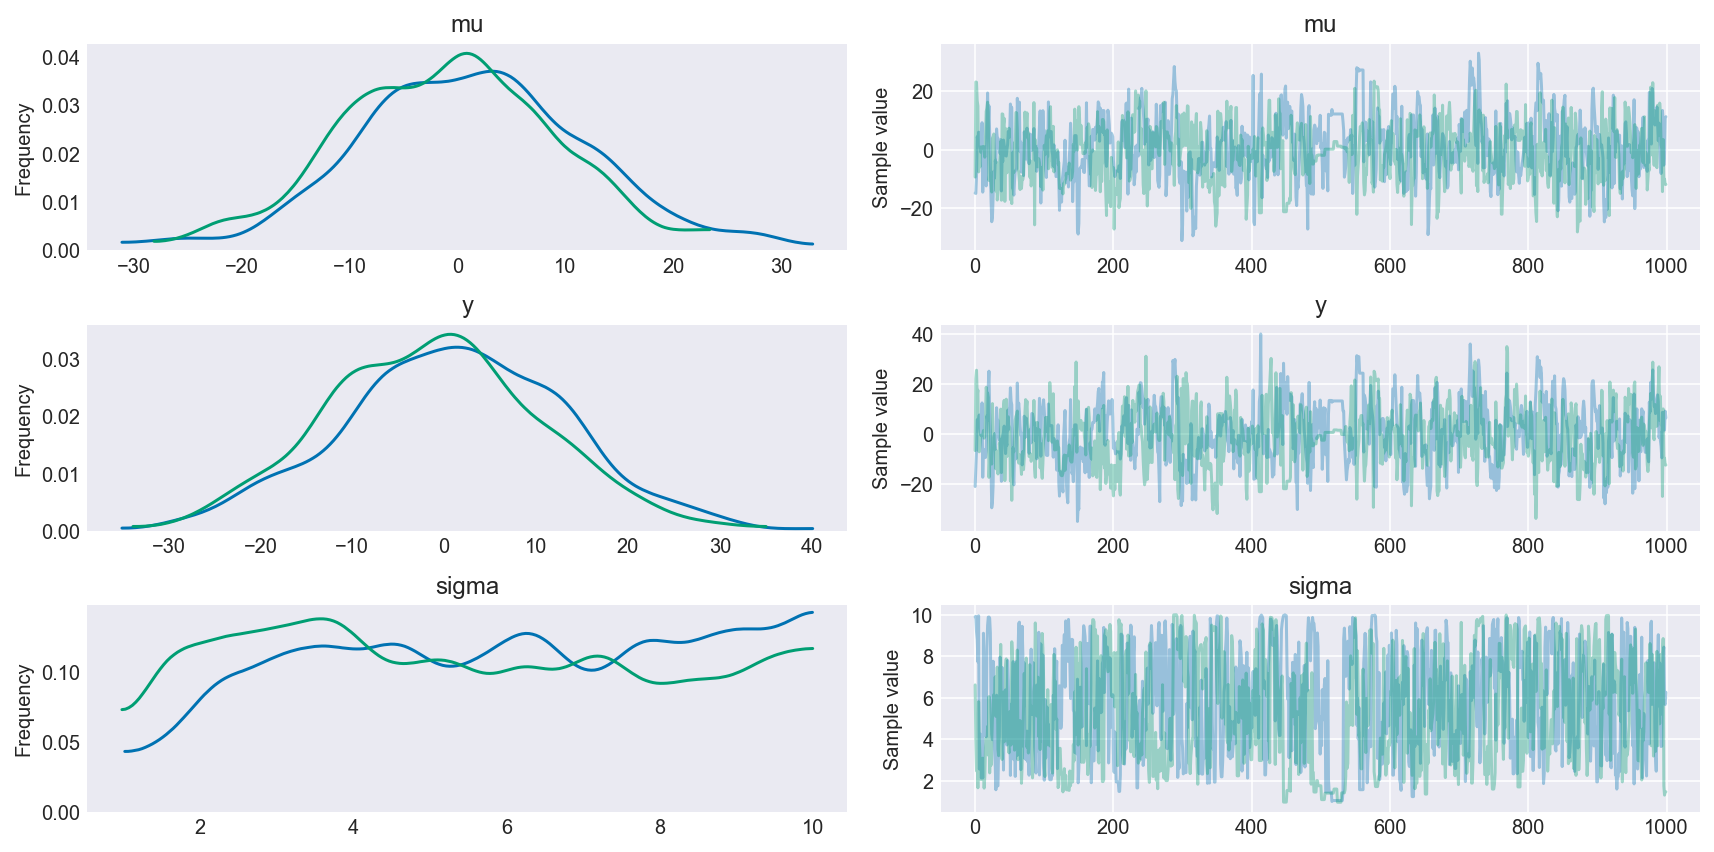

In [56]:
# 4M2
# Since we're already using pymc3, we'll translate this into a pymc3 model
with pm.Model() as m_4M2:
    mu=pm.Normal('mu',mu=0,sd=10)
    sigma=pm.Uniform('sigma',lower=0, upper=10)
    y=pm.Normal('y',mu=mu,sd=sigma)
    trace_4M2=pm.sample(1000,tune=1000)

pm.traceplot(trace_4M2); 

##### 4M3
y~Normal(mu,sigma)  
mu = alpha + beta*Xi  
alpha ~ Normal(0,50)  
beta ~ Uniform(0,10)  
sigma ~ Unifrom(0,50)  


##### 4M4

height ~ Normal (mu,sigma)

mu = alpha + beta * year[i]  

alpha ~ Normal(140,20)
beta ~ Normal(5,3) 
sigma ~ Uniform(0,50)  
  
Alpha is still the mean height. With no further information, we just pick a prior that seems plausible.  
Beta is now [year] and not [weight]. The prior I have, Normal(5,3), means on avg the students will grow 5CM per year.  

##### 4M5
alpha ~ Normal(120,20)
beta ~ Normal(5,2)

we center the mean at 120cm. And make beta a bit smaller so that 5-2sd is still >0

##### 4M6
sigma ~ Uniform(0,8)
we cap the upper bound of SD at 8, since variance is never more than 64cm



In [50]:
# 4H1

individual = list(range(1, 6))
weight = (46.95, 43.72, 64.78, 32.59, 54.63)
weight_df=pd.DataFrame({
    'individual':individual,
    'weight':weight,
})

print(d.head())
print(weight_df.head())

    height     weight   age  male   weight_c
0  151.765  47.825606  63.0     1   2.835121
1  139.700  36.485807  63.0     0  -8.504679
2  136.525  31.864838  65.0     0 -13.125648
3  156.845  53.041915  41.0     1   8.051429
4  145.415  41.276872  51.0     0  -3.713614
   individual  weight
0           1   46.95
1           2   43.72
2           3   64.78
3           4   32.59
4           5   54.63


In [6]:
with pm.Model() as m_4h1:
    alpha = pm.Normal('alpha',mu=154,sd=100)
    beta = pm.Normal('beta',mu=0.5,sd=1)
    # mu=alpha+beta*d.weight_c
    mu = pm.Deterministic('mu', alpha + beta * d.weight)
    sigma=pm.Uniform('sigma',lower=0,upper=50)
    height=pm.Normal('height',mu=mu,sd=sigma,observed=d.height)
    trace_4h1=pm.sample(1000,tune=1000)
    
# Questions
# What is alpha? when centered, it is weight at avg, when not centered, it's weight at 0
# What is the sigma in Alpha? What is the Sigma in the formula?
# Sigma in alpha is the width of the distribution of mean height. Sigma in prior means distribution of height around around mean.
# How do I determine the mu and sd for Beta? Beta is the relationship b/t weight and height. zero means no relationship.
# there for it is the most conservative guess.
# Althought it doesn't make sense the that weight has a positive impact on height is just as likely as weight having
# negative impact on height. so the prior really should be positive
# What is the right way to use the model for prediction, do we need to sample from posterior for the new inputs?
# sample_posterior_predictive()?


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains: 100%|███████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 537.13draws/s]


In [7]:
pm.summary(trace_4h1, alpha=.11,varnames=['alpha','beta','sigma']).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
alpha,113.87,2.00,0.07,110.89,117.09,665.49,1.0
beta,0.91,0.04,0.00,0.84,0.97,669.95,1.0
sigma,5.11,0.19,0.01,4.82,5.43,1046.00,1.0


In [10]:
def f(x):
    y=trace_4h1['alpha'].mean()+trace_4h1['beta'].mean()*x
    return y
def f_min(x):
    y=pm.hpd(trace_4h1['alpha'],0.11)[0]+pm.hpd(trace_4h1['beta'],0.11)[0]*x
    return y

def f_max(x):
    y=pm.hpd(trace_4h1['alpha'],0.11)[1]+pm.hpd(trace_4h1['beta'],0.11)[1]*x
    return y

weight_df['height'] = weight_df['weight'].apply(f)
weight_df['height_5.5'] = weight_df['weight'].apply(f_min)
weight_df['height_94.5'] = weight_df['weight'].apply(f_max)

In [11]:
weight_df

,individual,weight,height,height_5.5,height_94.5
0,1,46.95,156.367156,150.164983,162.033653
1,2,43.72,153.463305,147.470299,158.924961
2,3,64.78,172.396777,165.039973,179.194018
3,4,32.59,143.457153,138.184902,148.212966
4,5,54.63,163.271671,156.572158,169.425218
